In [1]:
#analyticky - derivaci jenom jedna sada krivek a nekolik thresholdu
#TODO tabulka/GRAF/oboji. 
import sympy as sp
from abtem import Probe
import numpy as np
import matplotlib.pyplot as plt
a, l, C10, C30, C50=sp.symbols("a, l, C10, C30, C50")
chi=2*sp.pi/l*(1/2*C10*a**2+1/4*C30*a**4+1/6*C50*a**6)
diff=sp.diff(chi,a)

aberrations = {
    'C30': 0.88e-3/1e-10,
    'C50': 0.81e-3/1e-10}
probe_dummy=Probe(energy=30e3,**aberrations)

In [2]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (10, 10)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
                'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
common={C30:aberrations["C30"],C50:aberrations["C50"],l:probe_dummy.wavelength}
defocus,alpha=sp.symbols("defocus,alpha")
diff_f=sp.lambdify((defocus,alpha),diff.evalf(subs=common).evalf(subs={C10:-defocus,a:alpha}))
chi_f=sp.lambdify((defocus,alpha),chi.evalf(subs=common).evalf(subs={C10:-defocus,a:alpha}))

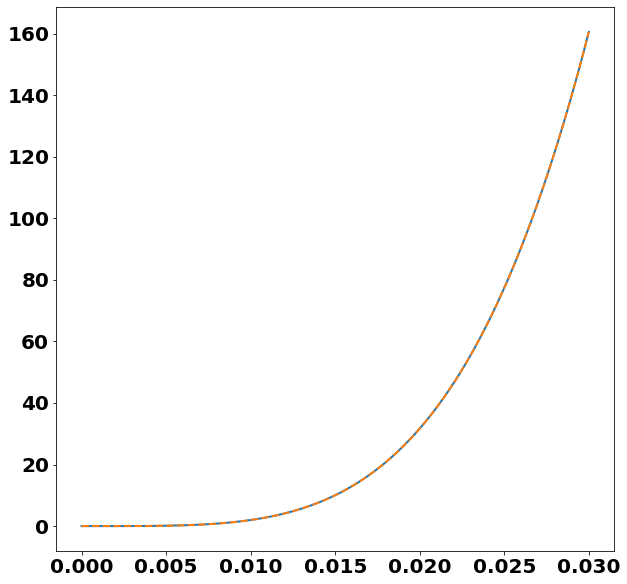

In [4]:
x=np.linspace(0,30e-3,100) # in rad
plt.plot(x,chi_f(0,x))
plt.plot(x,probe_dummy.ctf.evaluate_chi(x,0),"--")

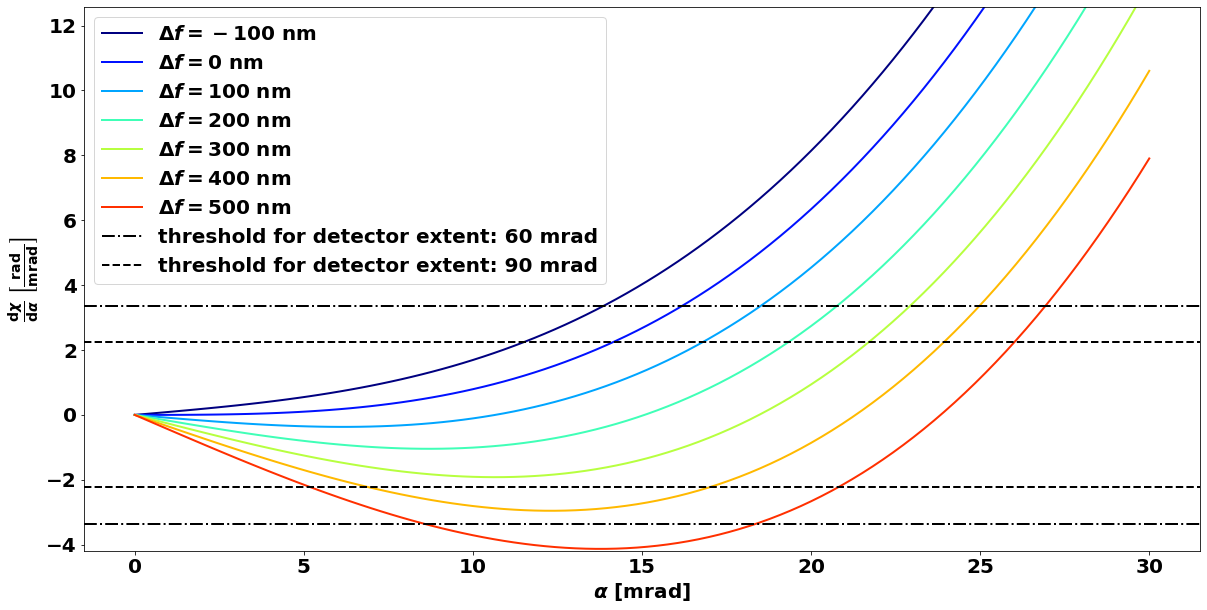

In [5]:
plt.figure(figsize=(20,10))

semiangles_detector_rad=np.array([60,90])*1e-3 # in rad
gpts_detector=256
angular_sampling_detector_rad=semiangles_detector_rad*2/gpts_detector

# instead of plotting quantity corresponding to phase shift in rad when moving one pixel in a detector I am ploting only d(chi)/d(alpha) and thresholds corresponding to d(chi)/d(alpha)*(angularangular_sampling_detector)=pi/2-> d(dhi)/d(alpha)=1/(angular_sampling_detector)*pi/2
cmap = plt.get_cmap("jet")
defocuses=np.linspace(-1000,5000,7)
for i,defocus in enumerate(defocuses):
    plt.plot(x*1e3,diff_f(defocus,x)/1e3,color=cmap(i/len(defocuses)),label=r"$\Delta f = {:.0f}~\mathrm{{nm}}$".format(defocus/10))
thresholds=1/angular_sampling_detector_rad*np.pi/2
linestyles=["-.","--","dotted"]
for i,threshold in enumerate(thresholds):
    plt.axhline(y=threshold/1e3,color="k",linestyle=linestyles[i])
    plt.axhline(y=-threshold/1e3,color="k",linestyle=linestyles[i],label="threshold for detector extent: {:.0f} mrad".format(semiangles_detector_rad[i]*1e3))

#plt.xlim(0,30)
ma=max(thresholds)
ylim=ma+ma/4
plt.ylim(-ylim/1e3,ylim*3/1e3)
#plt.xlim(None,30)
plt.xlabel(r"$\alpha~[\mathrm{mrad}]$")
plt.ylabel(r"$\frac{\mathrm{d}\chi}{\mathrm{d}\alpha}$ $\left[\frac{\mathrm{rad}}{\mathrm{mrad}}\right]$")
plt.legend()
plt.savefig("report/02_figs_sampling_restriction_on_defocus/threshold.pdf")

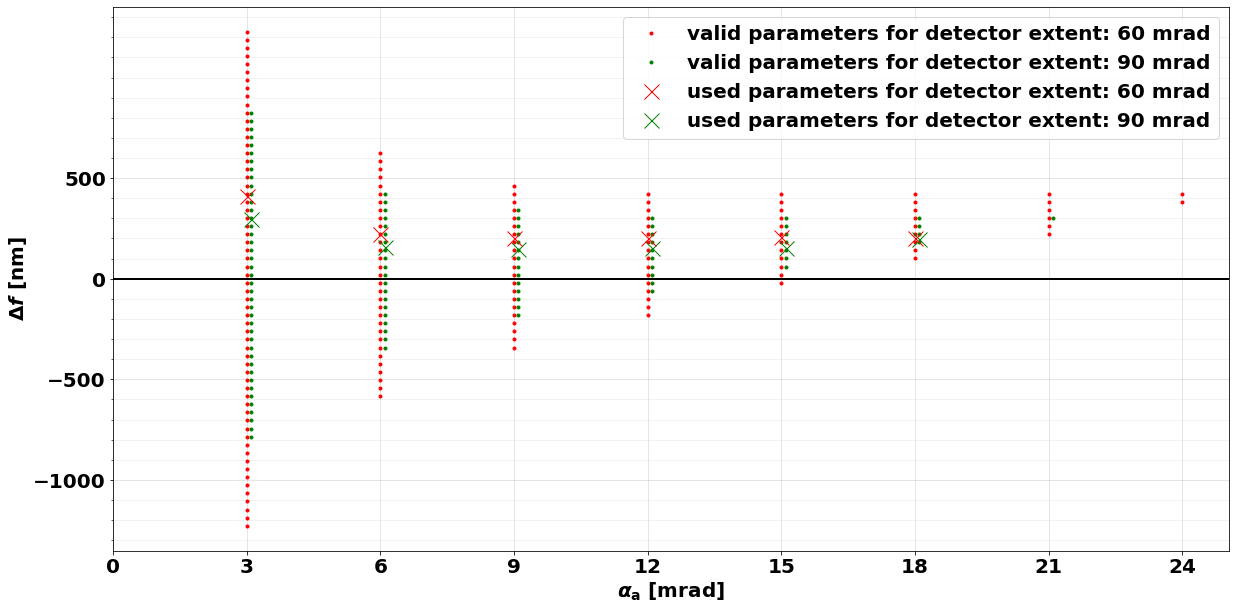

In [6]:
plt.figure(figsize=(20,10))
plt.axhline(y=0,color="k",linestyle="-")
defocuses=np.linspace(-30000,30000,150)
semiangles_cutoff=np.linspace(3,30,10)
ploting_steps=[0,0.1,0.2]

colors=["r","g","b"]

for i_semiangle_detector in range(len(semiangles_detector_rad)):
    for i_semiangle_cutoff in range(len(semiangles_cutoff)):
        angles_mrad=np.linspace(-semiangles_cutoff[i_semiangle_cutoff]*1e-3,semiangles_cutoff[i_semiangle_cutoff]*1e-3,500)
        for i_defocus,defocus in enumerate(defocuses):
            threshold = thresholds[i_semiangle_detector]
            maximum = np.max(np.abs(diff_f(defocus,angles_mrad)))
#            if maximum < threshold*2/3:
            if maximum < threshold:
                plt.plot(semiangles_cutoff[i_semiangle_cutoff]+ploting_steps[i_semiangle_detector],defocus/10,".",color=colors[i_semiangle_detector])
plt.xlim(0,None)
plt.xlabel(r"$\alpha_\mathrm{a}~[\mathrm{mrad}]$")
plt.ylabel(r"$\Delta f~[\mathrm{nm}]$")

for i_semiangle_detector in range(len(semiangles_detector_rad)): # podpera
    label="valid parameters for detector extent: {:.0f} mrad".format(1e3*semiangles_detector_rad[i_semiangle_detector])
    plt.plot(-10,0,".",color=colors[i_semiangle_detector],label=label)
for i_semiangle_detector in range(len(semiangles_detector_rad)): # podpera
    label_cross="used parameters for detector extent: {:.0f} mrad".format(1e3*semiangles_detector_rad[i_semiangle_detector])
    plt.plot(-10,0,"x",markersize=15,color=colors[i_semiangle_detector],label=label_cross)
    

ylim=plt.gca().get_ylim()
xlim=plt.gca().get_xlim()
plt.gca().set_yticks(np.arange(np.round(ylim[0],-3),np.round(ylim[1],-3), 500))
plt.gca().set_xticks(np.arange(np.round(xlim[0],0),np.round(xlim[1],0), 3))
plt.gca().grid(which='major', alpha=0.4)
plt.gca().grid(which='minor', alpha=0.2)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(100))


####
import pandas as pd
#col_dict={30.0:0,60.0:1,90.0:2}
col_dict={60.0:0,90.0:1}
    
sweep_params_pd_ = pd.read_csv("sweep_params.csv")
sweep_params_pd = sweep_params_pd_[sweep_params_pd_["semiangle_detector"]>50] # skip semiangle_detector 30 mrad
for idx in sweep_params_pd.index:
    par=sweep_params_pd.iloc[idx]
    col_idx=col_dict[par["semiangle_detector"]]
    plt.plot(par["semiangle_cutoff"]+ploting_steps[col_idx],par["defocus"]/10,"x",markersize=15,color=colors[col_idx])
    

    

plt.legend()
plt.savefig("report/02_figs_sampling_restriction_on_defocus/valid_defocus.pdf")
